In [1]:
import math
import pandas as pd
import numpy as np
import networkx as nx
import csv
import random
import matplotlib.pyplot as plt
import statistics 
from scipy import stats
from scipy.spatial import distance
import io
import time#for recording time 
import sys #for getting size of object
!pip install texttable
from texttable import Texttable

plt.rcParams["figure.figsize"] = (10,10)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
random.seed(15)

### *Importing files from github for google colab


In [3]:
url = 'https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/contact_rules.csv'
rules_df  = pd.read_csv(url,header=None,engine='python')
url2='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/frequency_contact.csv'
frequency_df= pd.read_csv(url2,header=None,engine='python')
url3='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/varicella_prevalance.csv'
V_prevalence_df =pd.read_csv(url3,header=None,engine='python')
url4='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/population.csv'
population_df=pd.read_csv(url4,header=None,engine='python')

### *importing files from pc


frequency_df = pd.read_csv('frequency_contact.csv',header=None)
population_df = pd.read_csv('population.csv',header=None)
V_prevalence_df = pd.read_csv('varicella_prevalance.csv',header=None)
rules_df = pd.read_csv('contact_rules.csv',header=None)

# THE GRAPH CONTROL PANEL

In [4]:
N =1000# Number of nodes
setting='home'    #the setting we are evaluating(home,work,school,other)
fit_factor=.75
birth_rate=.03

## 1-Defining Nodes

In [5]:
#defining a dictionary of nodes

group_popularity = dict() #based on consensus year 95
v_prevalence=dict() #based on meta analysis(data is not exact!! update needed!!)contan(age_group,prevalance,lower CL)
nodes_dic=dict() #dictionary of nodes
frequency=dict()


for i, row in population_df.iterrows():
    group_popularity[row[0]]=float(row[1])
    
for i, row in V_prevalence_df.iterrows():
    v_prevalence[row[0]]=[float(row[1]),float(row[2])]
    

#importing data for frequency of contact in each setting for comparison
for i, row in frequency_df.iterrows():
    frequency[row[0]]=dict()
    for i in range(1,6):
        frequency[row[0]][i]=float(row[i])
                    
for i in range(N):#deciding nodes ages
    while True:
        r=random.random()
        t=random.choice(list(group_popularity.keys()))
        if r<=group_popularity[t]:
            nodes_dic[i]={'age':t}
            break


for i in range(N):  #deciding nodes seropositivity
    a=v_prevalence[nodes_dic[i]['age']][0]
    b=v_prevalence[nodes_dic[i]['age']][1]
    r=np.random.random()
    t=np.random.normal(a,(a-b)) 
    if r<=t:
        nodes_dic[i]['infection']=1
    else:
        nodes_dic[i]['infection']=0
        

### Which `group` each node belongs to?

* We  used `Age specific population for Iran` to define probability of each group

In [6]:

# the number of nodes in each group:

age_count = {}
for n in nodes_dic.keys():
    
    if nodes_dic[n]['age'] in age_count:
        age_count[nodes_dic[n]['age']] = age_count[nodes_dic[n]['age']] + 1
    else:
        age_count[nodes_dic[n]['age']] = 1
age_count

{'20_24': 96,
 '5_9': 76,
 '55_59': 43,
 '50_54': 51,
 '30_34': 122,
 '0_4': 88,
 '10_14': 68,
 '25_29': 99,
 '75+': 22,
 '35_39': 86,
 '40_44': 58,
 '15_19': 60,
 '70_74': 16,
 '65_69': 18,
 '45_49': 63,
 '60_64': 34}

## 2-Defining Connection Rules between Node Groups

### `We define rules in terms of connection probability between each two groups`


In [7]:
#importing rules_data from .csv to nested dictionary
rules_data={}  # rules_data contain ->{location:{contactor:{contactee:contact number}
temp_0={}
temp_1={}
location=[]
contactor=[]
contactee=[]
contact_number=[]

for i, row in rules_df.iterrows():
    
    location.append(row[0])
    contactor.append(row[1])
    contactee.append(row[2])
    contact_number.append(float(row[3]))

for o in range (0,1280,256):
    for m in range(o,o+256,16):
        for n in range (m,m+16):
            
            temp_0[contactee[n]]=contact_number[n]
        temp_1[contactor[m]]=temp_0.copy()
    rules_data[location[o]]=temp_1.copy()     

In [8]:
#transformin rules_data to rules so it will be symetrical

rules=dict()

for i in rules_data.keys():
    rules[i]=dict()
    for j in rules_data[i].keys():
        rules[i][j]=dict() 
        for k in rules_data[i][j].keys():

            total_j_k_contact=(rules_data[i][j][k]*age_count[j])+(rules_data[i][k][j]*age_count[k])
            rules[i][j][k]=(total_j_k_contact/2)/age_count[j]

In [9]:
#claculating how many contact a person has with all age groups in the setting
#calculating how many 'connectons' is required for the contacts with specific frequency
rules_sum=dict()
for i in rules.keys():
    rules_sum[i]=dict()
    for j in rules[i].keys():
        t=0
        rules_sum[i][j]={'contact_total':0,'count1':0,'count2':0,'count3':0}
        for k in rules[i][j]:
            t+=rules[i][j][k]
    
        rules_sum[i][j]['contact_total']=t
        rules_sum[i][j]['count1']=t*frequency[i][1]
        rules_sum[i][j]['count2']=t*frequency[i][2]*(7/1.5)
        rules_sum[i][j]['count3']=t*frequency[i][3]*(30/1.5)
        #number of 'contacts' with random probability
        rules_sum[i][j]['count4']=t*(frequency[i][4]+frequency[i][5])
        rules_sum[i][j]['connection_total']=rules_sum[i][j]['count1']+rules_sum[i][j]['count2']+rules_sum[i][j]['count3']
        
        
#a dictionary of weight/upper_weight ratio for each frequency set       
frequency_grouped={1:1,2:(1.5/7),3:(1.5/30),4:0}

table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['setting','age','contact_total','connection_total','conection 1','conection 2' ,'conection 3','connection 4']])      
print(table.draw())
for i in rules_sum.keys():
    for j in rules_sum[i].keys():
        
        table.add_rows([[i,j,'%f' % rules_sum[i][j]['contact_total'],'%f' % rules_sum[i][j]['connection_total'],'%f' % rules_sum[i][j]['count1'],'%f' % rules_sum[i][j]['count2'],'%f' % rules_sum[i][j]['count3'],'%f' % rules_sum[i][j]['count4']]])
        
        print(table.draw())


setting   age   contact_t   connecti   conectio   conectio   conectio   connecti
                  otal      on_total     n 1        n 2        n 3        on 4  
  all     0_4   10.430289   49.72575   3.980407   12.70241   33.04293   2.075789
                               4                     7          0               
  all     10_   21.755269   103.7168   8.302246   26.49442   68.92022   4.329636
          14                   89                    2          0               
  all     15_   20.112049   95.88293   7.675160   24.49324   63.71453   4.002610
          19                   8                     4          3               
  all     20_   11.349825   54.10958   4.331320   13.82226   35.95599   2.258791
          24                   3                     3          9               
  all     25_   12.104958   57.70963   4.619494   14.74189   38.34824   2.409074
          29                   1                     4          3               
  all     30_   12.234464   

## 3-Defining Rules to Connecting Nodes and Adjusting `Weights`

* This would be the step that our Naive graph would evolve over the time through a simulation process
* we monitor connection between nodes and update weights based on connections

In [10]:
#in this block we've defiend a function "Run" 
def Run(nodes_dic,age_count,frequency_grouped):
    
    #building the array based on nodes_dic
    #graph_array=[N * [[connecetions],[weights],number of the node]
    graph_array=[]
    for i in range(N):
        graph_array.append([[],[],i])
      
    #making a dictionary that consists of lists of nodes in each age group
    nodes_age_grouped=dict() 
    for i in range(N):     
        if nodes_dic[i]['age'] in nodes_age_grouped:
            nodes_age_grouped[nodes_dic[i]['age']].append(i)    
        else:
            nodes_age_grouped[nodes_dic[i]['age']]=[i]
    
    #Copyin age_count to age_available
    age_available=dict()
    for i in age_count.keys():
        age_available[i]=age_count[i]
   
    #iterating nodes
    for contactor in range(N-1):
        
        #print(contactor)
        
        Age=nodes_dic[contactor]['age']
        contact=rules_sum[setting][Age]['contact_total']
        count1=rules_sum[setting][Age]['count1']
        count2=rules_sum[setting][Age]['count2']
        count3=rules_sum[setting][Age]['count3']
        connection=rules_sum[setting][Age]['connection_total']
        list_count={2:count2,3:count3}
        
        #building families
        if graph_array[contactor][0]==[]:
            #age_available is for storing number of nodes without household in each age
            age_available[Age]-=1
            
            #deciding the size of house hold
            #the fit_factor helps for reducing houeholdsize
            pop_house=np.random.poisson(lam=(count1*fit_factor))
            counter=0
            contactee=contactor+1 #for iterating in graph
            
            
            while counter < pop_house :
                
                #in case we iterate all all available nodes but no connection is formed
                if contactee==N:
                    contactee=contactor+1
                 
                #in case there is not enough nodes to build the household
                if sum(list(age_available.values()))==0:
                    break
                    
                r=random.random()
                #age contactee
                Age_c=nodes_dic[contactee]['age']
                #age_p_pooled is used to get the probability of contact considering all nodes already in family
                age_p_pooled=rules[setting][Age][Age_c]/(len(graph_array[contactor][0])+1)
                for m in graph_array[contactor][0]:
                    age_p_pooled+=(rules[setting][nodes_dic[m]['age']][Age_c]/(len(graph_array[contactor][0])+1))
                    
                
                if graph_array[contactee][0]==[] :#if the node doesn't already belong to a family
                    if rules[setting][Age][Age_c]!=0:
                        if r <= age_p_pooled/(contact* age_available[Age_c]):

                            age_available[Age_c]-=1
                            counter+=1
                            
                            Family=graph_array[contactor][0][:] #list of nodes already in household

                            graph_array[contactor][0].append(contactee)
                            graph_array[contactor][1].append(1)

                            graph_array[contactee][0].append(contactor)
                            graph_array[contactee][1].append(1)

                            #connecting the contactee with other nodes in family
                            
                            for m in range(len(Family)):

                                graph_array[contactee][0].append(Family[m])
                                graph_array[contactee][1].append(1)

                                graph_array[Family[m]][0].append(contactee)
                                graph_array[Family[m]][1].append(1)

                contactee+=1 #iterating in graph
                                  
    #building other connections than families
    
    for contactor in range(N):
        
        Age=nodes_dic[contactor]['age']
        contact=rules_sum[setting][Age]['contact_total']
        count1=rules_sum[setting][Age]['count1']
        count2=rules_sum[setting][Age]['count2']
        count3=rules_sum[setting][Age]['count3']
        connection=rules_sum[setting][Age]['connection_total']
        list_count={2:count2,3:count3}
        #deciding number of connections,(/2) is ecause connections are formed both ways
        k =np.random.poisson(lam=((count2+count3)/2))
        
        counter=0
        while counter<k:

            r=random.random()
            #deciding the age of connection of the node
            t=random.choice(list(nodes_age_grouped.keys()))
            if rules[setting][Age][t]!=0:
                
                min_age_count=min(list(age_count.values()))
                
                if r <= (rules[setting][Age][t])*(min_age_count/age_count[t])/(contact):

                    #deciding the weight of connection of the node
                    r2=random.random()
                    t2=random.randint(2,3)
                    if r2 <= list_count[t2]/(count2+count3) :

                        #deciding a random node from the chosen age group to make connection
                        contactee=random.choice(nodes_age_grouped[t])

                        if contactee not in graph_array[contactor ][0]:
                            if contactee != contactor:

                                graph_array[contactor ][0].append(contactee)
                                graph_array[contactor ][1].append(t2)

                                graph_array[contactee][0].append(contactor )
                                graph_array[contactee][1].append(t2)

                        counter+=1
                            
                            
#putting data from graph to a list of connections
    connections_list=list()
    for i in range(N):
        for j in range(len(graph_array[i][0])):
            k=graph_array[i][0][j]
            l=graph_array[i][1][j]
            if i<k:
                connections_list.append((i,k,l))
            elif k<i:
                connections_list.append((k,i,l))
    #removing duplicates
    connections_list=list(set(connections_list))
    
                             
    results={'graph_array':graph_array,'nodes_age_grouped':nodes_age_grouped,'connections':connections_list}                           
    return(results)


In [11]:
#this defines a function for aging the graph
def G_age(nodes_dict,graph_dict):
    return()
    

In [12]:
#Run_S runs the model and stores conections but do not change the weights
def Run_S (nodes_dic,N_day,rules,age_count,N,results):
    
    nodes_age_grouped=results['nodes_age_grouped']
    graph_array=results['graph_array']
    connections=results['connections']

    #in this list the day that connection has happened is stored
    #contacts=[N*[D0[],D1[]]]
    contacts=[] 
    for i in range(N):
        contacts.append([])
        
            
    for d in range(N_day):
        #adding empty list for day to each node
        for i in range(N):
            contacts[i].append([])
         #checking if contacts happen and storing them   
        for j in connections:
                r=random.random()
                if frequency_grouped[j[2]]>=r:
                    contacts[j[0]][d].append(j[1])
                    contacts[j[1]][d].append(j[0])
             
            #checking for random contacts between i and other nodes 
            #number of random contacts
        for i in range(N):
            count_random=rules_sum[setting][nodes_dic[i]['age']]['count4']
            for k in range(np.random.poisson(lam=(count_random))):

                while True:
                    r=random.random()
                    #deciding the age of connection of the node
                    t=random.choice(list(nodes_age_grouped.keys()))
                    age_p=rules[setting][nodes_dic[i]['age']][t]
                    if age_p!=0:
                        if r <= age_p/rules_sum[setting][nodes_dic[i]['age']]['contact_total'] :
                            #deciding a random node from the chosen age group to make connection
                            t2=random.choice(nodes_age_grouped[t])
                            #making sure t2 and i had no connection and no contact before
                            if (t2 not in graph_array[i][0]) and (t2 not in contacts[i][d]):
                                contacts[i][d].append(t2)
                                break
                            
        
    
    return(contacts)

# 4- Monitroing the graph
### we monitor the graph for age specific number of contact per day and frequeny of contact

In [13]:
#this function returns p_value wilcoxon for comparison age stratified number of contacts 
 #And the mean of absoloute error for age stratified number of contact divided by age stratified number of contact

def Metric_W(Run_S,age_count,rules) : 
    

    contacts=Run_S
    
    
    L1=[]
    L2=[]
    L3=[]
    

    rules_m=dict()
    rules_m[setting]=dict()

    for i in rules[setting].keys():
        rules_m[setting][i]=dict()
        for j in rules[setting][i].keys():
             rules_m[setting][i][j]=0
    
    for i in range(N):
            for j in contacts[i][0]:
                age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]
                if i!=j and age_p!=0 : 
                    t= 1/age_count[nodes_dic[i]['age']]
                    rules_m[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]+=t
                         
    for i in rules_m[setting].keys():
        for j in rules_m[setting][i].keys():
            
            L1.append(rules[setting][i][j])
            L2.append(rules_m[setting][i][j])
            if rules[setting][i][j]!=0:
                L3.append(abs((rules_m[setting][i][j])-(rules[setting][i][j]))/rules[setting][i][j])
            else:
                L3.append(0)
                
    wilx=stats.wilcoxon(L1,L2,zero_method='wilcox', correction=False, alternative='two-sided')
    M_Abs=statistics.mean(L3)
    #Manhattan distance
    man_dis=distance.cityblock(L1, L2)
    #Euclidean distance
    eu_dis=distance.euclidean(L1,L2)
    #Chebyshev distance
    cheb_dis=distance.chebyshev(L1,L2)
    #Pearson corelation
    prs_cor=stats.pearsonr(L1,L2)
    
    
    Metric_W ={'wilx':wilx,'M_Abs':M_Abs,'rules_m':rules_m,'L3':L3,'man_dis':man_dis,'eu_dis':eu_dis,'cheb_dis':cheb_dis, 'prs_cor': prs_cor}
    
    return(Metric_W)

In [14]:
#defining a function that returns mean absoloute error 'frequency of contacts ' in the last x day of model
def metric_F(Run_S,results,age_count):
    
    contacts=Run_S
    n=0
    graph_array=results['graph_array']
    
    L1=[]
    L2=[]
    
    frequency_m=dict()
    for i in frequency.keys():
        frequency_m[i]={1:0,2:0,3:0,4:0}

    for i in range(N):
        #contacts at day zero
        for j in contacts[i][0]:
            #for nodes with contact and connection
            if j in graph_array[i][0]:  
            #finding the weight of i*j
                position=0
                for k in graph_array[i][0]:
                    if k==j:
                        t=graph_array[i][1][position]
                        
                    position+=1

            #for nodes with contact but not connection(random nodes)        
            elif j not in graph_array[i][0]:
                t=0
                
            n+=1

            if t==0  :
                frequency_m[setting][4]+=1


            elif t==1:
                frequency_m[setting][1]+=1


            elif t==2:
                frequency_m[setting][2]+=1


            elif  t==3:

                frequency_m[setting][3]+=1



                        
                    
    for i in frequency_m[setting].keys():
        if n!=0:
        
            frequency_m[setting][i]=frequency_m[setting][i]/n
        if n==0:
            
            frequency_m[setting][i]=0
    
    
    return(frequency_m)

In [15]:
start = time.time()

# evaluating results
### this part of code evaluates results of  function Run for the inputs

###### Run -> input : increase_ratio,D,nodes_dic
###### Run -> output : contacted_all, G, weight_all, group_count


In [16]:
#this part runs the model
results=Run(nodes_dic,age_count,frequency_grouped)


In [17]:
end=time.time()

In [18]:
#running a 1 day simulation of model
contacts=Run_S(nodes_dic,1,rules,age_count,N,results)

In [19]:
#this part returns the absoloute error for age stratified number of contact
Metr_W=Metric_W(contacts,age_count,rules)



In [20]:
#this part shows number of age stratified contact from data and model for comparision
t=0
L3=Metr_W['L3']
table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['age i','age j','rules_m  ',' rules  ','Abs_error']])

print(table.draw())

for i in rules[setting].keys():
    
    for j in rules[setting][i].keys():
        
        model=Metr_W["rules_m"][setting][i][j]
        data=rules[setting][i][j]
        table.add_rows([[i,j,'%f' %  model,'%f' % data,'%f' % L3[t]]])
        print(table.draw())
        t+=1

        

age i   age j    rules_m      rules    Abs_error
 0_4     0_4    0.443182    0.439130   0.009227 
 0_4     5_9    0.409091    0.535432   0.235960 
 0_4    10_14   0.306818    0.339040   0.095040 
 0_4    15_19   0.204545    0.181596   0.126378 
 0_4    20_24   0.363636    0.357210   0.017990 
 0_4    25_29   0.488636    0.652748   0.251417 
 0_4    30_34   0.625000    0.852899   0.267205 
 0_4    35_39   0.568182    0.649060   0.124608 
 0_4    40_44   0.295455    0.299186   0.012472 
 0_4    45_49   0.159091    0.168363   0.055070 
 0_4    50_54   0.170455    0.217748   0.217195 
 0_4    55_59   0.136364    0.240038   0.431909 
 0_4    60_64   0.181818    0.217282   0.163216 
 0_4    65_69   0.181818    0.078233   1.324058 
 0_4    70_74   0.011364    0.029562   0.615603 
 0_4     75+    0.034091    0.028746   0.185925 
10_14    0_4    0.338235    0.438758   0.229108 
10_14    5_9    0.426471    0.607497   0.297988 
10_14   10_14   0.632353    0.794020   0.203606 
10_14   15_19   0.32

graph of data


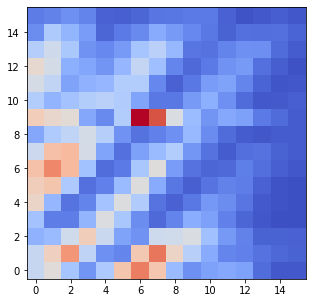

graph of model


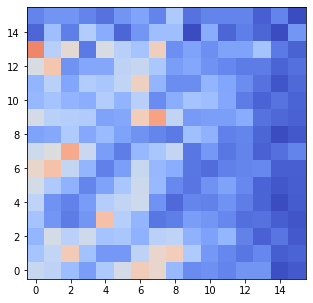

In [21]:
#heat map

plt.rcParams["figure.figsize"] = (5,5)

color_graph=[]

V_max=0 

for i in rules[setting].keys():
    color_graph.append([])
    for j in rules[setting][i]:
        color_graph[-1].append(rules[setting][i][j])
        if V_max<rules[setting][i][j]:
            V_max=rules[setting][i][j]
    
print('graph of data')       
plt.pcolor(range(0,16,1),range(0,16,1),color_graph,shading='auto', cmap='coolwarm',vmin=0,vmax=V_max)
plt.show()

color_graph_m=[]

for i in Metr_W["rules_m"][setting].keys():
    color_graph_m.append([])
    for j in Metr_W["rules_m"][setting][i]:
        color_graph_m[-1].append(Metr_W["rules_m"][setting][i][j])
        if V_max<Metr_W["rules_m"][setting][i][j]:
            V_max=Metr_W["rules_m"][setting][i][j]
    

print('graph of model')          
plt.pcolor(range(0,16,1),range(0,16,1),color_graph_m,shading='auto', cmap='coolwarm',vmin=0,vmax=V_max)
plt.show()

In [22]:
#this part returns p_value wilcoxon for comparison age stratified number of contacts 

print('p-value wilcoxon :','%f' % Metr_W['wilx'][1])

print('Pearson Corealtion :',Metr_W['prs_cor'][0],'%f' % Metr_W['prs_cor'][1])

print('mean absoloute error : ', Metr_W['M_Abs'])

print('Manhattan distance :',Metr_W['man_dis'])

print('Euclidean distance :',Metr_W['eu_dis'])

print('Chebyshev distance :',Metr_W['cheb_dis'])

p-value wilcoxon : 0.050423
Pearson Corealtion : 0.8500088982213756 0.000000
mean absoloute error :  0.5641814816576916
Manhattan distance : 19.868461134498236
Euclidean distance : 1.6881503513488585
Chebyshev distance : 0.4508605555555558


red -> model blue->data
home : 1 // 0.688415 // 0.703030
home : 2 // 0.163370 // 0.154703
home : 3 // 0.094015 // 0.091225
home : 4 // 0.054200 // 0.051042


(0.0, 5.0, 0.0, 1.0)

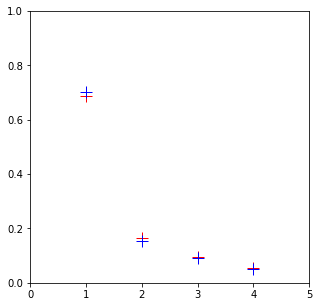

In [23]:
#this shows the fitting for frequency

results_F=metric_F(contacts,results,age_count)

plt.rcParams["figure.figsize"] = (5,5)

print('red -> model blue->data')

for i in results_F[setting].keys():
    L=list(frequency[setting].values())
    L[3]+=L[4]
    
    print (setting,':',i,'//','%f' % results_F[setting][i],'//','%f' % L[i-1])
    plt.plot(i,results_F[setting][i],'+r',linewidth=1, markersize=12,alpha=1)
    plt.plot(i,L[i-1],'+b',linewidth=1, markersize=12,alpha=1)
    
plt.axis([0,5,0,1])

In [24]:
print(end-start)

2.070665121078491


In [25]:
table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['frequency group','     data    ','     model    ']])
print(table.draw())

list_contacts={'data':{1:0,2:0,3:0,4:0,'tot':0},'model':{1:0,2:0,3:0,4:0,'tot':0}}
#based on rules_sum
for i in rules_sum[setting].keys():
    list_contacts['data'][1]+=rules_sum[setting][i]['count1']*age_count[i]
    list_contacts['data'][2]+=(rules_sum[setting][i]['count2']*(1.5/7))*age_count[i]
    list_contacts['data'][3]+=(rules_sum[setting][i]['count3']*(1.5/30))*age_count[i]
    list_contacts['data'][4]+=rules_sum[setting][i]['count4']*age_count[i]
    list_contacts['data']['tot']+=rules_sum[setting][i]['contact_total']*age_count[i]
    
#based on contacts
for i in contacts:
    list_contacts['model']['tot']+=len(i[0])
for i in results_F[setting].keys():
    list_contacts['model'][i]=(results_F[setting][i]*list_contacts['model']['tot'])

for i in list_contacts['data'].keys():
    
    table.add_rows([[i,'%f' %list_contacts['data'][i],'%f' %list_contacts['model'][i]]])
    print(table.draw())


        

frequency group          data            model  
       1           2803.729895     2680.000000  
       2           616.964918       636.000000  
       3           363.813146       366.000000  
       4           203.557711       211.000000  
      tot          3988.065670     3893.000000  


 age    house hold size data   house hold size model   population
 0_4          3.716409               3.147727            0.088   
10_14         4.064060               2.911765            0.068   
15_19         3.340160               3.066667             0.06   
20_24         1.960181               2.395833            0.096   
25_29         2.177942               2.353535            0.099   
30_34         2.454037               2.508197            0.122   
35_39         3.014318               2.837209            0.086   
40_44         2.875019               3.172414            0.058   
45_49         2.201329               1.936508            0.063   
 5_9          4.329986               3.157895            0.076   
50_54         2.377441               2.607843            0.051   
55_59         2.406336               2.860465            0.043   
60_64         2.530451               2.735294            0.034   
65_69         2.486699               3.222222            0.018   
70_74     

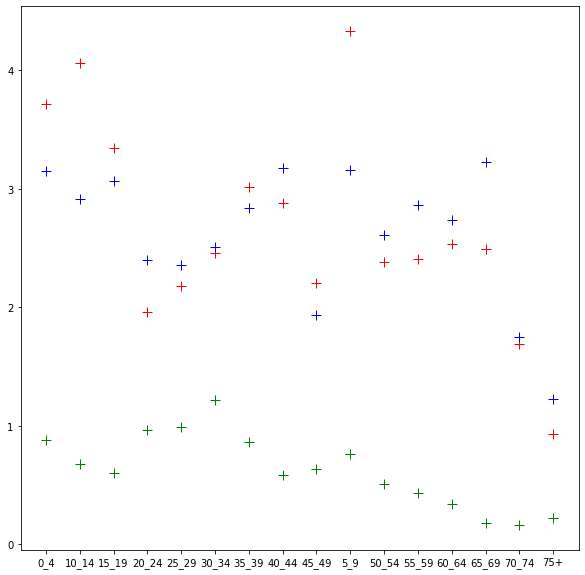

In [26]:
table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([[' age ','house hold size data','house hold size model','population']])
print(table.draw())
plt.rcParams["figure.figsize"] = (10,10)

house_hold_size={}
for i in age_count.keys():
    house_hold_size[i]=0
for i in results['graph_array']:
    Age=nodes_dic[i[2]]['age']
    house_hold_size[Age]+=(i[1].count(1)/age_count[Age])

for i in rules_sum[setting].keys():
    table.add_rows([[i,'%f' %rules_sum[setting][i]['count1'],'%f' %house_hold_size[i],age_count[i]/N]])
    print(table.draw())
    plt.plot(i,rules_sum[setting][i]['count1'],'r+',linewidth=2, markersize=10,alpha=1)
    plt.plot(i,house_hold_size[i],'b+',linewidth=2, markersize=10,alpha=1)
    plt.plot(i,age_count[i]/(N/10),'g+',linewidth=2, markersize=10,alpha=1)
    